In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Reading the data

I decided to use the anime forum data.

In [79]:
Badges = pd.read_xml('Badges.xml')
Comments = pd.read_xml('Comments.xml')
PostHistory = pd.read_xml('PostHistory.xml')
PostLinks = pd.read_xml('PostLinks.xml')
Posts = pd.read_xml('Posts.xml')
Tags = pd.read_xml('Tags.xml')
Users = pd.read_xml('Users.xml')
Votes = pd.read_xml('Votes.xml')

# Task 1

## Histogram

I want to make a histogram plot showing the distribution of the number of words in posts.

In [81]:
Posts.loc[:,'Body'].head()

0    <p>Assuming the world in the One Piece univers...
1    <p>In the middle of <em>The Dark Tournament</e...
2    <p>In Sora no Otoshimono, Ikaros carries aroun...
3    <p>Is there any particular software or softwar...
4    <p>In several episodes of DB:Z and DB:GT, usin...
Name: Body, dtype: object

The body of the post is in HTML format so to get the correct number of words I will remove the HTML tags.

In [83]:
def remove_html_tags(text): 
    clean = re.compile('<.*?>') 
    return re.sub(clean, '',text)

I want to count the number of words so I will also split them by the spaces and count.

In [85]:
Posts.loc[:,'PostLength'] = Posts.loc[:,'Body'].apply(lambda x: len(remove_html_tags(x).split()) if pd.notnull(x) else 0)

The plot is hard to read currently because there is very extreme outliers. I will be removing them.

In [87]:
Q1 = Posts.loc[:,'PostLength'].quantile(0.25) #first quantile
Q3 = Posts.loc[:,'PostLength'].quantile(0.75) #third quantile
IQR = Q3 - Q1 #interquartile range
Threshold = 3 
FilteredPosts = Posts[(Posts.loc[:,'PostLength'] >= (Q1 - Threshold * IQR)) & (Posts.loc[:,'PostLength'] <= (Q3 + Threshold * IQR))]

Now I have filtered out the extreme outliers.

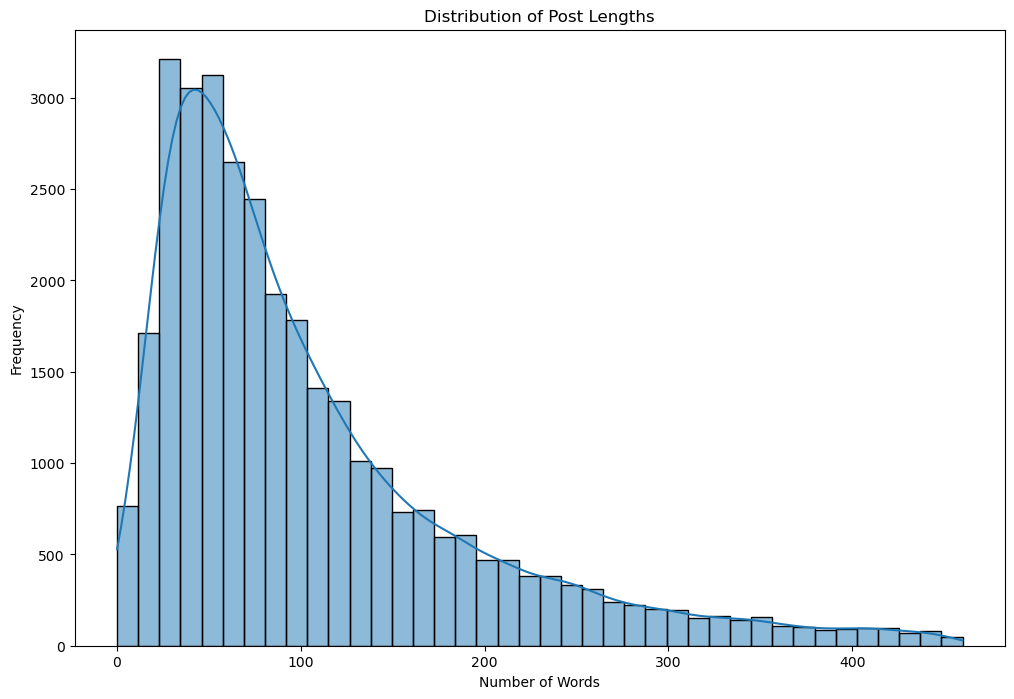

In [89]:
plt.figure(figsize=(12, 8)) 
sns.histplot(FilteredPosts.loc[:,'PostLength'], bins= 40, kde=True)
plt.xlabel('Number of Words') 
plt.ylabel('Frequency') 
plt.title('Distribution of Post Lengths') 
plt.show()

This plot shows the distrubution of post lengths based on the number of words. We can see from this plot that most of the posts are around 0 to 100 words. It can observed that as the number of words increases the frequency decreases.

## Bar Chart

I want to show the top 25 most awarded badges using a bar chart.

In [91]:
BadgeCount = Badges.loc[:,'Name'].value_counts().reset_index() #counting the number of occurances
BadgeCount.columns = ['BadgeName', 'Count'] 
TopBadge = BadgeCount.head(25) #filtering for the top 25

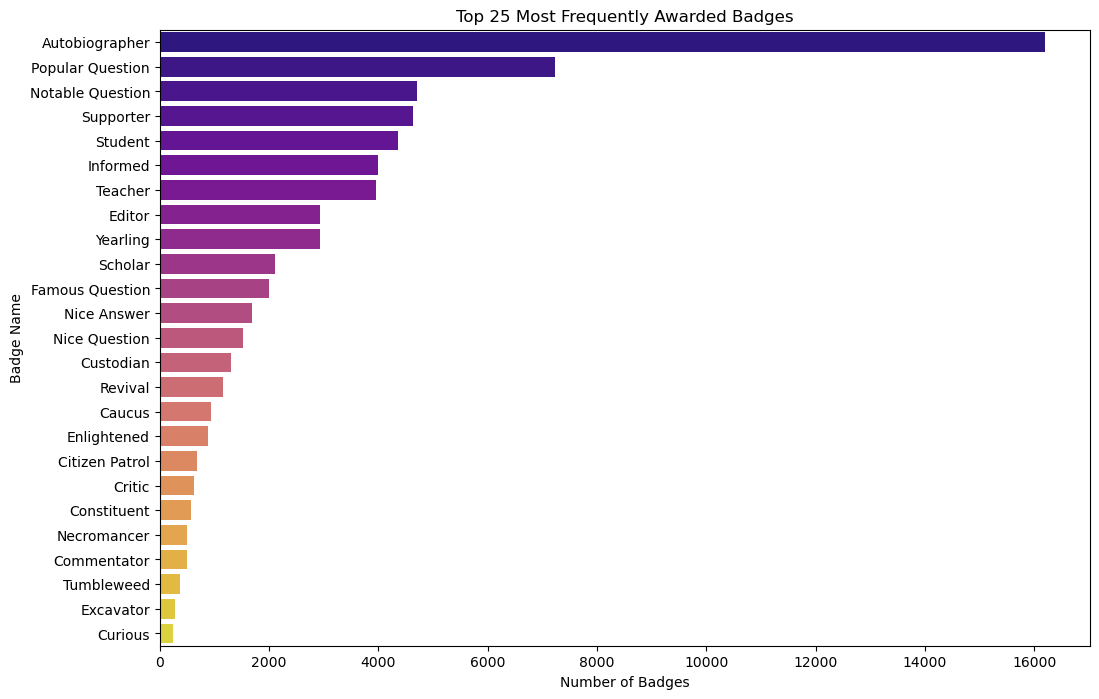

In [93]:
plt.figure(figsize=(12, 8)) 
sns.barplot(data=TopBadge, x='Count', y='BadgeName', hue='BadgeName', legend=False, palette='plasma') #using a palette to make it more visually appealing.
plt.xlabel('Number of Badges') 
plt.ylabel('Badge Name') 
plt.title('Top 25 Most Frequently Awarded Badges') 
plt.show()

This horizontal bar chart displays the number of times each of the top 25 badges has been awarded to users. The bars are color-coded, transitioning from dark blue for the most frequently awarded badges to light yellow for the least frequent. We can see that the "Autobiographer" badge is the most frequently awarded, followed by "Popular Question" and "Notable Question."

## Heatmap

I want to make a heatmap that will show the amount of registrations based on the year and month.

In [95]:
Users['CreationDate'] = pd.to_datetime(Users['CreationDate']) #converting to datetime.

In [97]:
Users.loc[:,'CreationYearMonth'] = Users.loc[:,'CreationDate'].dt.to_period('M') #transforming to month periods so we will have year and month.

In [99]:
UserReg = Users.loc[:,'CreationYearMonth'].value_counts().sort_index().reset_index() #grouping by the periods.
UserReg.columns = ['CreationYearMonth', 'Registrations']

Now I will pivot the data so it can be used for the heatmap.

In [105]:
UserRegPivot = UserReg.pivot_table(index=UserReg['CreationYearMonth'].dt.year,
                                                columns=UserReg['CreationYearMonth'].dt.month,
                                                values='Registrations', fill_value=0)

Months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
UserRegPivot.columns = [Months[col] for col in UserRegPivot.columns] #renaming the months to their names rather than their numbers


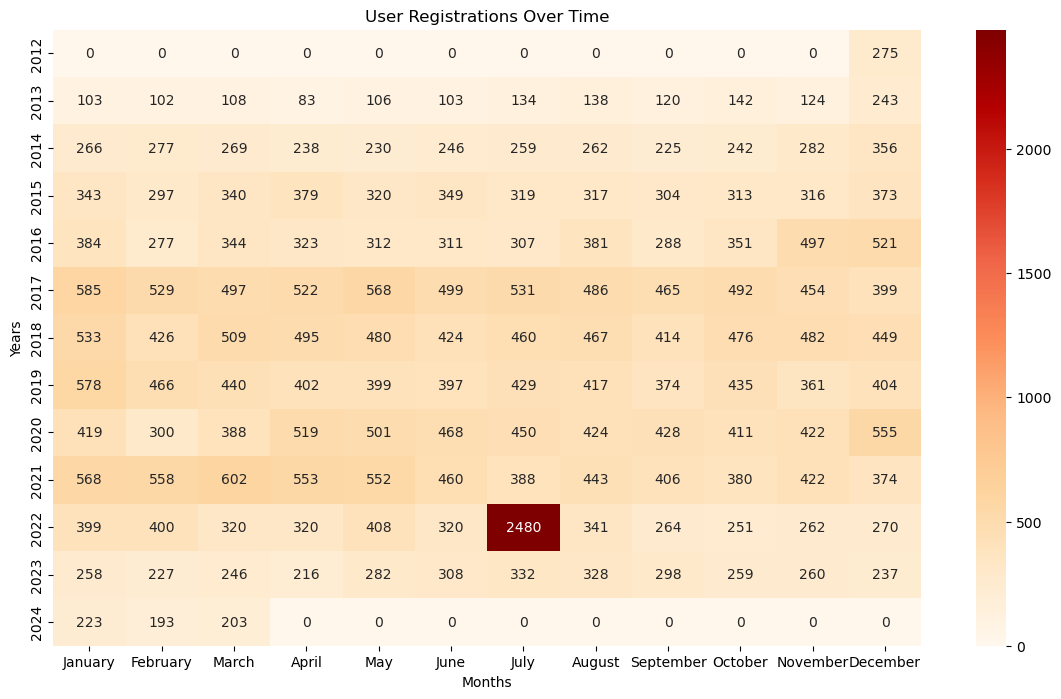

In [107]:
plt.figure(figsize=(14, 8))
sns.heatmap(UserRegPivot, cmap='OrRd', annot=True, fmt='.0f') #annot for showing the values on the boxes and color map for better visibility
plt.title('User Registrations Over Time')
plt.xlabel('Months')
plt.ylabel('Years')
plt.show()

The heatmap visualizes user registrations over time, with the x-axis representing months and the y-axis representing years. Each cell shows the count of registrations for that specific month and year. Darker colors indicate higher registration counts. We can easily observe that, the highest registration count is 2480, which occurred in July 2022.

## Line Chart

I want to make a line chart which will show the number of posts that has been created over time.

The process of getting the month and year from the 'CreationDate' is the same as the above heatmap process.

In [109]:
Posts['CreationDate'] = pd.to_datetime(Posts['CreationDate']) #converting to datetime format
Posts.loc[:,'YearMonth'] = Posts.loc[:,'CreationDate'].dt.to_period('M') #transforming to month periods so we will have year and month.

In [111]:
PostsTime = Posts.loc[:,'YearMonth'].value_counts().sort_index().reset_index() #grouping by the month periods
PostsTime.columns = ['YearMonth', 'PostCount']

Now I will select every 3 months to show on the chart because if all the months are shown the chart becomes clustered and unreadable.

In [113]:
PostsTime = PostsTime[PostsTime.index % 3 == 0]

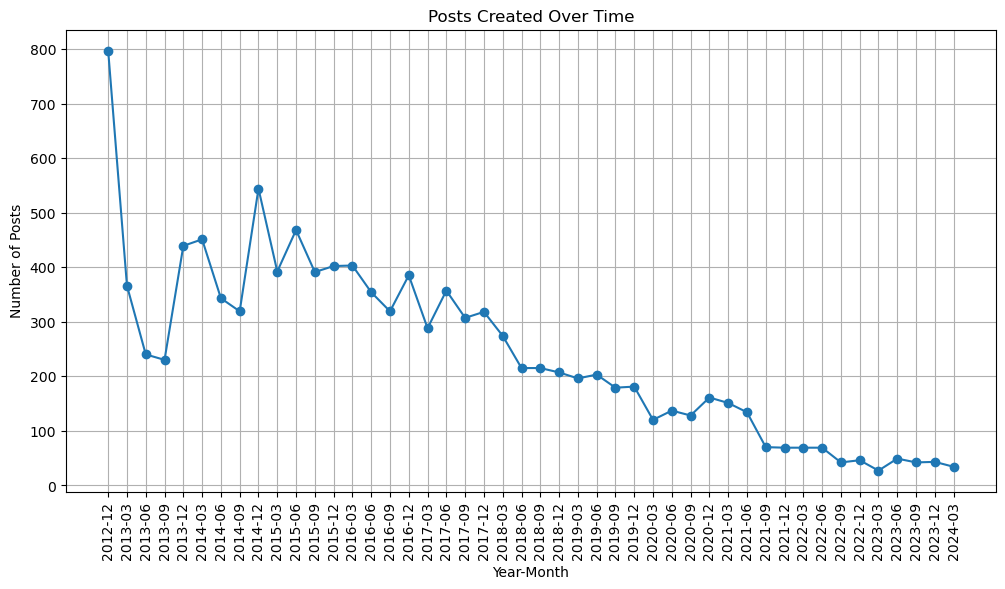

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(PostsTime.loc[:,'YearMonth'].astype(str), PostsTime.loc[:,'PostCount'], marker='o')
plt.xticks(rotation=90)
plt.title('Posts Created Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

In the above graph we only have data from every third month so the other months data is not being put to use. <br>
I realized that grouping the data by quarters would make use of all the data and the chart would be readable.

In [117]:
Posts['CreationDate'] = pd.to_datetime(Posts['CreationDate']) #converting to datetime format
Posts.loc[:, 'Quarter'] = Posts.loc[:, 'CreationDate'].dt.to_period('Q') #transforming to quarter periods

In [119]:
PostsTime = Posts.loc[:, 'Quarter'].value_counts().sort_index().reset_index() #grouping by the quarter periods
PostsTime.columns = ['Quarter', 'PostCount']
PostsTime['QuarterLabel'] = PostsTime.loc[:,'Quarter'].apply(lambda x: f'Q{x.quarter} {x.year}') #formatting the quarter string for better readability

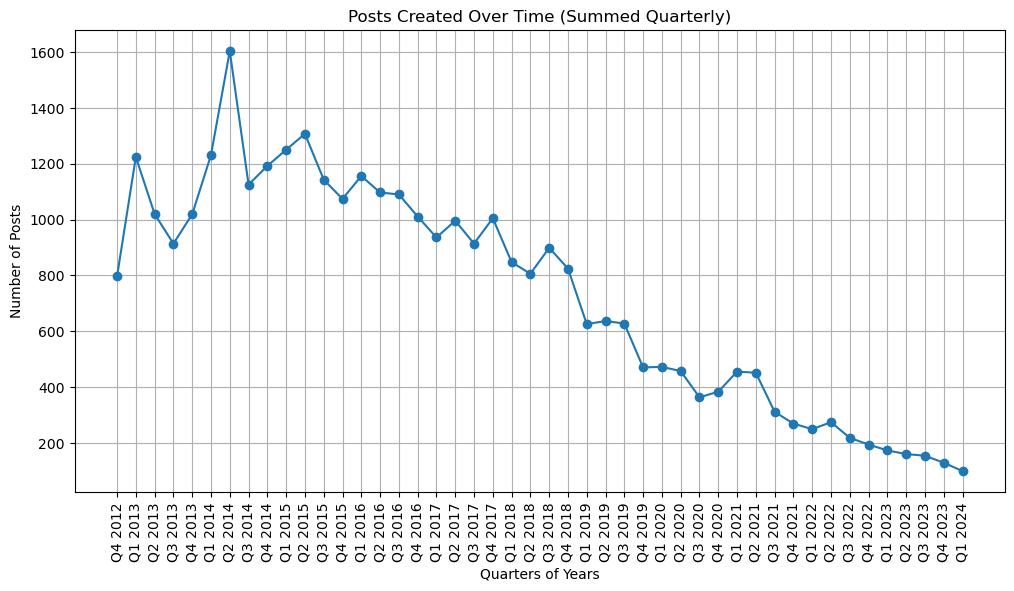

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(PostsTime.loc[:,'QuarterLabel'], PostsTime.loc[:,'PostCount'], marker='o')
plt.xticks(rotation=90)
plt.title('Posts Created Over Time (Summed Quarterly)')
plt.xlabel('Quarters of Years')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

The line plot visualizes the number of posts created over time, with the x-axis representing time quarterly intervals from 4th quarter of 2012 to 1st quarter of 2024, and the y-axis showing the number of posts. We can observe the prominent decrease of the number of posts through the years. <br>
We can also see that it is a bit different from the above plot which only showcases every 3rd month.

## Box-and-whiskers plot

I want to plot the view counts of the posts based on that posts tags. I will be only doing this for the top 10 tags.

In [123]:
ViewsTags = Posts.loc[:, ['ViewCount', 'Tags']]
ViewsTags = ViewsTags.dropna(subset=['ViewCount', 'Tags'])

I am applying log transformation to the view count values to improve the readability of the graph. After this every value x that is on our graph is actually going to be $e^x - 1.$

In [125]:
ViewsTags.loc[:,'LogViewCount'] = np.log1p(ViewsTags.loc[:,'ViewCount'])

Every post can include multiple tags because of that I will split the tags so that every row only includes one tag.

In [127]:
ViewsTags.loc[:,'Tags'] = ViewsTags.loc[:,'Tags'].apply(lambda x: x.strip('|').split('|'))
TagsExp = ViewsTags.explode('Tags')

Now I want to only have the views for the top 10 tags.

In [129]:
TagCount = TagsExp.loc[:,'Tags'].value_counts()
TopTags = TagCount.head(10).index 
FinalData = TagsExp[TagsExp.loc[:,'Tags'].isin(TopTags)]

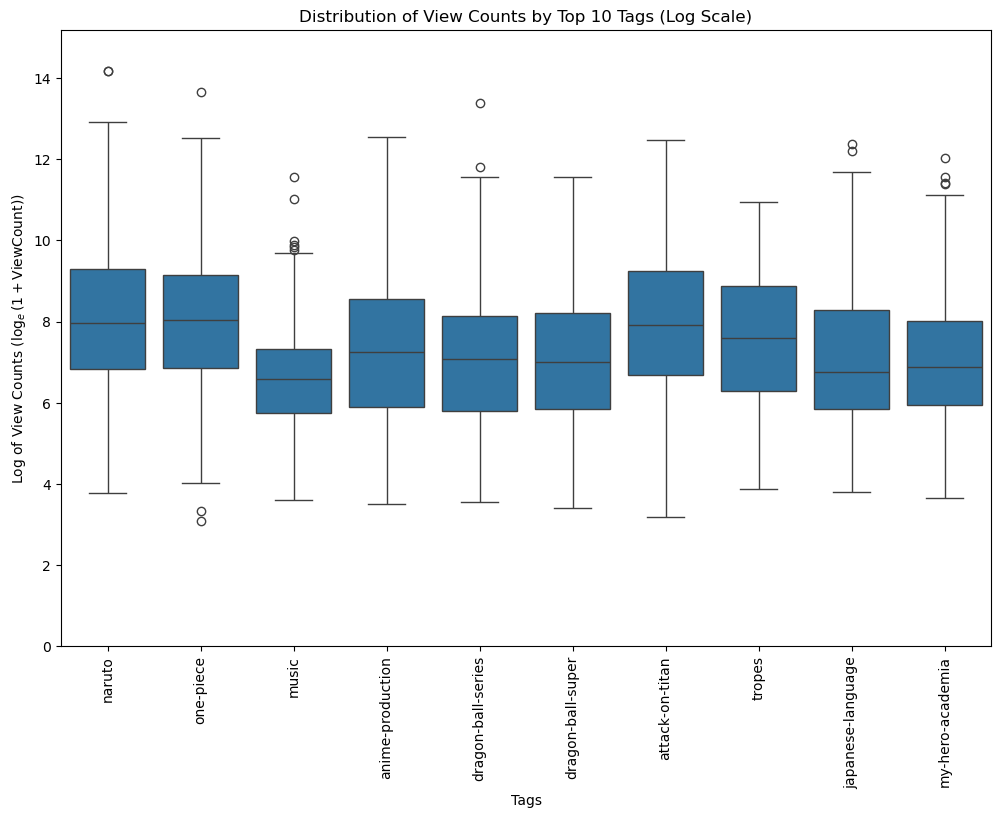

In [131]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=FinalData, x='Tags', y='LogViewCount', order=TopTags) #Tags are ordered from left to right starting from most used.
plt.xlabel('Tags')
plt.ylabel(r'Log of View Counts ($\log_e (1 + \text{ViewCount})$)')
plt.title('Distribution of View Counts by Top 10 Tags (Log Scale)')
plt.ylim(0, FinalData.loc[:,'LogViewCount'].max() + 1) #making the graph start from 0.
plt.xticks(rotation=90)
plt.show()

This box plot shows the log-transformed view counts $\log_e (1 + \text{ViewCount})$ for the top 10 tags on posts. Each box represents the range of view counts for a tag, highlighting the median, interquartile range (IQR), and any outliers. We can observe that all the tags have a big range of views.

# Task 2

#### My query to ChatGPT: <br>
"Can u make a plot using python based on the stackexchange data from the anime forum which has Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes. I already have them as pandas dataframes" <br>
Then I was asked which specific plot and I asked for Votes Per Post Type. <br>
#### Code Generated by ChatGPT:

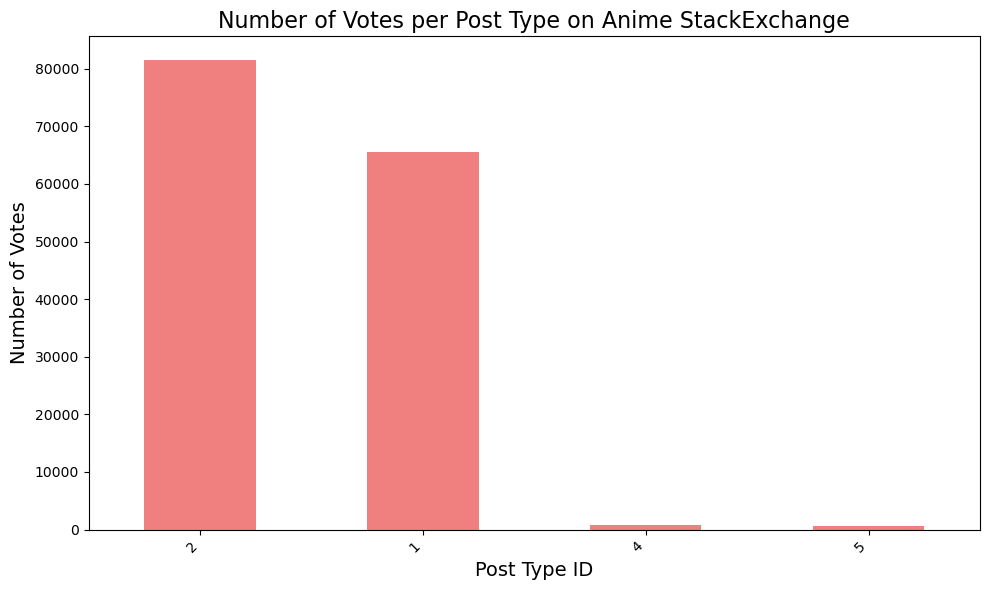

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Posts' and 'Votes' DataFrames are already loaded.

# Merge Posts with Votes to count the number of votes per post type
votes_per_post_type = (
    Posts[['Id', 'PostTypeId']]  # Get post IDs and their types
    .merge(Votes, left_on='Id', right_on='PostId', how='inner')
    .groupby('PostTypeId')       # Group by post type ID
    .size()                      # Count the number of votes per post type
    .sort_values(ascending=False)  # Sort in descending order
)

# Plot the results
plt.figure(figsize=(10, 6))
votes_per_post_type.plot(kind='bar', color='lightcoral')
plt.title('Number of Votes per Post Type on Anime StackExchange', fontsize=16)
plt.xlabel('Post Type ID', fontsize=14)
plt.ylabel('Number of Votes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The bar chart displays the number of votes on posts based on their type. We can see that Posts with type ID 2 have the most amount of votes followed by Post Type ID 1. There is also posts with type ID 4 and 5 but they have quite low amount of votes compared to 1 and 2.

The chart overall shows what it's supposed to show. We can specify what the post type ID number stands for to improve the graph. We can also write the actual numbers of votes for the types on the bar to make it more readable. Figure is overall very simple and not interesting.

#### 2nd query to ChatGPT: <br>
Can u make a plot about the user growth overtime using python based on the stackexchange data from the anime forum which has Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes. I already have them as pandas dataframes <br>
#### Code Generated by ChatGPT:

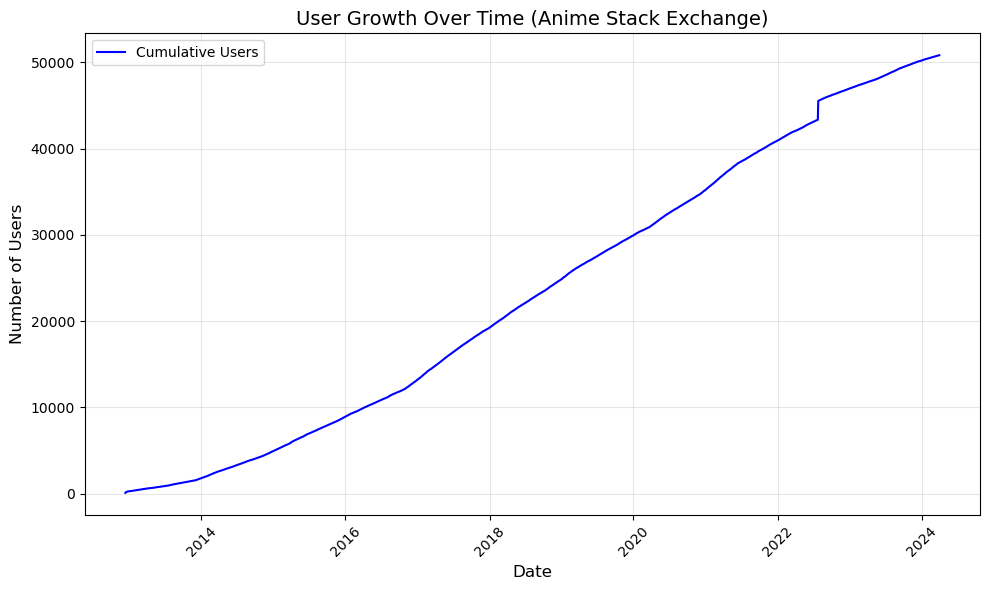

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'Users' DataFrame with a 'CreationDate' column
# Convert 'CreationDate' to datetime if it's not already
Users['CreationDate'] = pd.to_datetime(Users['CreationDate'])

# Group users by the creation date
Users['Date'] = Users['CreationDate'].dt.date  # Extract the date (ignoring time)
user_growth = Users.groupby('Date').size().cumsum()  # Cumulative sum of users

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(user_growth.index, user_growth.values, label='Cumulative Users', color='blue')
plt.title('User Growth Over Time (Anime Stack Exchange)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

The line plot shows user growth over time, the x-axis represents the time using years and y-axis shows the number of users. The legend specifies that it is cumulative sum of the users. <br> 
I think this plot is not bad at all. We can add more x-ticks for more years and can add a marker on the line so we can see the specific values more clearly. Also rotation was not needed for the x-ticks I think it makes it unreadable.